In [155]:
import pandas as pd

In [156]:
train = pd.read_csv('../data/gridloss/train.csv')
train['time'] = pd.to_datetime(train['Unnamed: 0'])

In [157]:
train = train[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        17520 non-null  datetime64[ns]
 1   grid1-load  17520 non-null  float64       
 2   grid1-loss  17519 non-null  float64       
 3   grid1-temp  17518 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 547.6 KB


In [159]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import random

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set_style("whitegrid")  # Apply a cleaner grid style

In [160]:
class NN(nn.Module):
    def __init__(self, input_size, output_size, learning_rate):
        """
        Define the layers of the neural network.

        Parameters:
            input_size: int
                The size of the input, in this case 784 (28 x 28).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, output_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.loss = nn.L1Loss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train_model(self, X, y, batch_size, num_epochs, learning_rate):
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        loss_history = []

        for epoch in tqdm(range(num_epochs)):
            self.train()
            running_loss = 0.0

            for inputs, targets in dataloader:
                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self(inputs)

                # Compute loss
                loss = self.loss(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            # Compute average loss for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            loss_history.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        return loss_history
    def evaluate_model(self, X_test, y_test):
        """
        Evaluate the model on test data and display predictions for 4 random time series instances.

        Parameters:
            model: NN
                Trained neural network model.
            X_test: np.array
                Test input data (shape [samples, features * 24], where each feature has 24 time steps).
            y_test: np.array
                Test target data (time series predictions of shape [samples, 24]).
        """
        # Set model to evaluation mode
        self.eval()

        # Convert test data to PyTorch tensors
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(self.device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(self.device)

        # Disable gradient computation for evaluation
        with torch.no_grad():
            # Get predictions
            outputs = self(X_test_tensor)
            predicted = outputs.cpu().numpy()
            #true_values = y_test_tensor.cpu().numpy()
        
        return predicted

In [161]:
input_size = 72  # 3 time series x24 hours pixels
forecast_horizon = 24  # 24 hours into future
learning_rate = 0.001
batch_size = 1
num_epochs = 100

In [162]:
model = NN(input_size=input_size, output_size=forecast_horizon, learning_rate=0.001)

In [163]:
def create_training_windows(df: pd.DataFrame, input_cols: list, target_col: str, window_size: int, forecast_horizon: int):
    df = df.dropna().reset_index(drop=True)

    num_samples = len(df) - window_size - forecast_horizon + 1
    if num_samples <= 0:
        raise ValueError("Not enough data to create windows.")

    # Initialize lists to hold the input-output pairs
    X, y = [], []

    for i in range(num_samples):
        # Select input window
        input_window = df.loc[i:i + window_size - 1, input_cols].values.flatten()
        
        # Select target window (forecast horizon)
        target_window = df.loc[i + window_size:i + window_size + forecast_horizon - 1, target_col].values.flatten()
        
        X.append(input_window)
        y.append(target_window)

    return np.array(X), np.array(y)


In [164]:
train.loc[0:24, ['grid1-loss', 'grid1-load', 'grid1-temp']].values.flatten()

array([ 18.766, 449.532, 267.85 ,  18.02 , 439.036, 267.55 ,  18.246,
       442.237, 267.25 ,  18.645, 447.836, 266.95 ,  19.823, 463.995,
       267.05 ,  23.797, 514.748, 267.15 ,  29.153, 576.118, 267.25 ,
        30.826, 593.987, 267.35 ,  30.551, 591.086, 267.45 ,  30.275,
       588.167, 267.55 ,  30.115, 586.467, 268.45 ,  30.162, 586.967,
       269.25 ,  29.928, 584.461, 268.75 ,  30.01 , 585.342, 269.45 ,
        31.   , 595.818, 270.15 ,  31.071, 596.56 , 270.85 ,  30.341,
       588.865, 271.45 ,  29.032, 574.806, 272.15 ,  28.401, 567.903,
       272.75 ,  26.774, 549.709, 273.15 ,  25.105, 530.383, 273.55 ,
        23.21 , 507.564, 273.95 ,  21.094, 480.803, 274.75 ,  18.908,
       451.493, 275.65 ,  17.327, 429.053, 275.75 ])

In [165]:
train.loc[24:24+24-1, 'grid1-loss']

24    17.327
25    16.474
26    15.908
27    15.743
28    15.725
29    16.165
30    17.240
31    18.928
32    20.891
33    22.304
34    22.569
35    22.096
36    21.691
37    21.449
38    21.938
39    22.411
40    22.581
41    22.042
42    21.089
43    19.813
44    18.761
45    17.542
46    16.187
47    15.646
Name: grid1-loss, dtype: float64

In [166]:
# Define input and target columns
input_columns = [
    "grid1-load", 
    "grid1-temp", 
    "grid1-loss"
]
target_column = "grid1-loss"
window_size = 24

X, y = create_training_windows(train, input_columns, target_column, window_size, forecast_horizon)

print("X shape:", X.shape)  # Should be (num_samples, window_size * 3)
print("y shape:", y.shape)  # Should be (num_samples, forecast_horizon)

X shape: (17471, 72)
y shape: (17471, 24)


In [167]:
X[0]

array([449.532, 267.85 ,  18.766, 439.036, 267.55 ,  18.02 , 442.237,
       267.25 ,  18.246, 447.836, 266.95 ,  18.645, 463.995, 267.05 ,
        19.823, 514.748, 267.15 ,  23.797, 576.118, 267.25 ,  29.153,
       593.987, 267.35 ,  30.826, 591.086, 267.45 ,  30.551, 588.167,
       267.55 ,  30.275, 586.467, 268.45 ,  30.115, 586.967, 269.25 ,
        30.162, 584.461, 268.75 ,  29.928, 585.342, 269.45 ,  30.01 ,
       595.818, 270.15 ,  31.   , 596.56 , 270.85 ,  31.071, 588.865,
       271.45 ,  30.341, 574.806, 272.15 ,  29.032, 567.903, 272.75 ,
        28.401, 549.709, 273.15 ,  26.774, 530.383, 273.55 ,  25.105,
       507.564, 273.95 ,  23.21 , 480.803, 274.75 ,  21.094, 451.493,
       275.65 ,  18.908])

In [168]:
y[0]

array([17.327, 16.474, 15.908, 15.743, 15.725, 16.165, 17.24 , 18.928,
       20.891, 22.304, 22.569, 22.096, 21.691, 21.449, 21.938, 22.411,
       22.581, 22.042, 21.089, 19.813, 18.761, 17.542, 16.187, 15.646])

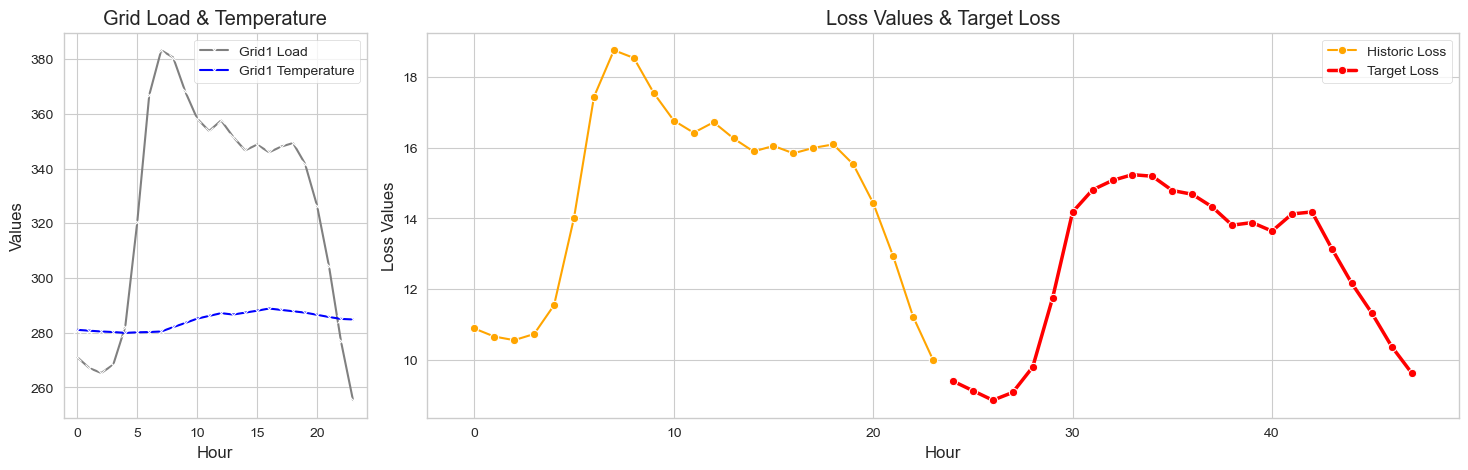

In [169]:
def plot_data(X, y):
    # Plotting the first few samples
    fig = plt.figure(figsize=(18, 5))
    random_index = np.random.randint(0, X.shape[0])

    # Create subplots with specific widths
    ax_left = plt.subplot2grid((1, 4), (0, 0), colspan=1)
    ax_right = plt.subplot2grid((1, 4), (0, 1), colspan=3)

    hours = np.arange(X.shape[1] // 3)
    target_hours = np.arange(len(hours), len(hours) + len(y[0]))

    load_values = X[random_index][0::3]
    temp_values = X[random_index][1::3]
    loss_values = X[random_index][2::3]

    # Left plot: Grid Load and Temperature
    sns.lineplot(x=hours, y=load_values, ax=ax_left, label="Grid1 Load", marker='x', color='grey')
    sns.lineplot(x=hours, y=temp_values, ax=ax_left, label="Grid1 Temperature", marker='x', color='blue')
    ax_left.set_title("Grid Load & Temperature")
    ax_left.set_xlabel("Hour")
    ax_left.set_ylabel("Values")
    ax_left.legend()
    ax_left.grid(True)

    # Right plot: Loss values
    sns.lineplot(x=hours, y=loss_values, ax=ax_right, label="Historic Loss", marker='o', color='orange', linewidth=1.5)

    # Right plot: Target Loss values (forecast horizon)
    sns.lineplot(x=target_hours, y=y[random_index], ax=ax_right, label="Target Loss", marker='o', color='red', linewidth=2.5)

    ax_right.set_title("Loss Values & Target Loss")
    ax_right.set_xlabel("Hour")
    ax_right.set_ylabel("Loss Values")
    ax_right.legend()
    ax_right.grid(True)

    plt.show()

plot_data(X, y)

In [170]:
loss_history = model.train_model(X, y, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate)

 12%|█▏        | 12/100 [00:00<00:05, 16.35it/s]

Epoch [10/100], Loss: 1.9848


 22%|██▏       | 22/100 [00:01<00:04, 15.92it/s]

Epoch [20/100], Loss: 1.8738


 32%|███▏      | 32/100 [00:01<00:04, 15.94it/s]

Epoch [30/100], Loss: 1.8389


 42%|████▏     | 42/100 [00:02<00:03, 16.18it/s]

Epoch [40/100], Loss: 1.8254


 52%|█████▏    | 52/100 [00:03<00:02, 16.14it/s]

Epoch [50/100], Loss: 1.7937


 62%|██████▏   | 62/100 [00:03<00:02, 15.51it/s]

Epoch [60/100], Loss: 1.7613


 72%|███████▏  | 72/100 [00:04<00:01, 16.00it/s]

Epoch [70/100], Loss: 1.7497


 82%|████████▏ | 82/100 [00:05<00:01, 15.73it/s]

Epoch [80/100], Loss: 1.7590


 92%|█████████▏| 92/100 [00:05<00:00, 15.31it/s]

Epoch [90/100], Loss: 1.7286


100%|██████████| 100/100 [00:06<00:00, 15.77it/s]

Epoch [100/100], Loss: 1.7201


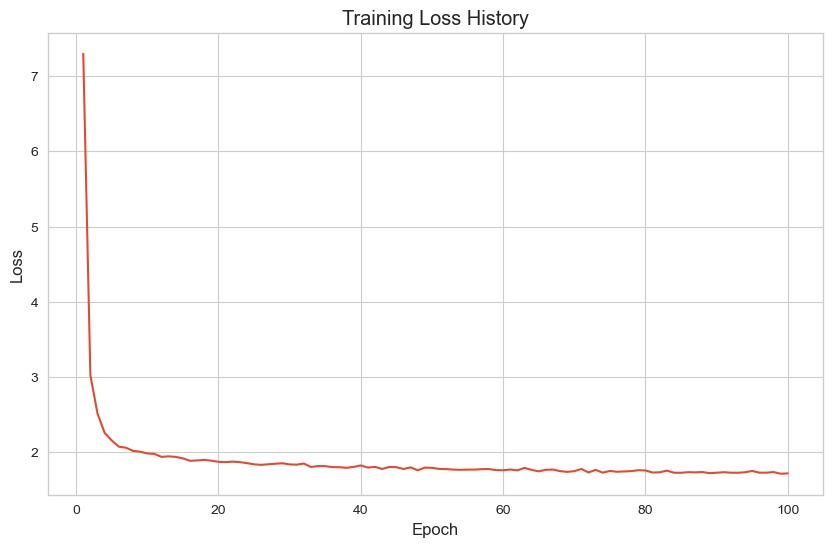

In [171]:
# Plot loss history using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [172]:
test = pd.read_csv('../data/gridloss/test_backfilled_missing_data.csv')
test['time'] = pd.to_datetime(test['Unnamed: 0'])
test = test[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [173]:
X_test, y_test = create_training_windows(test, input_columns, target_column, window_size, forecast_horizon)

In [174]:
predicted = model.evaluate_model(X_test, y_test)

In [175]:
evaluation_score = np.mean(np.abs(predicted - y_test))
evaluation_score

2.5294375611296616

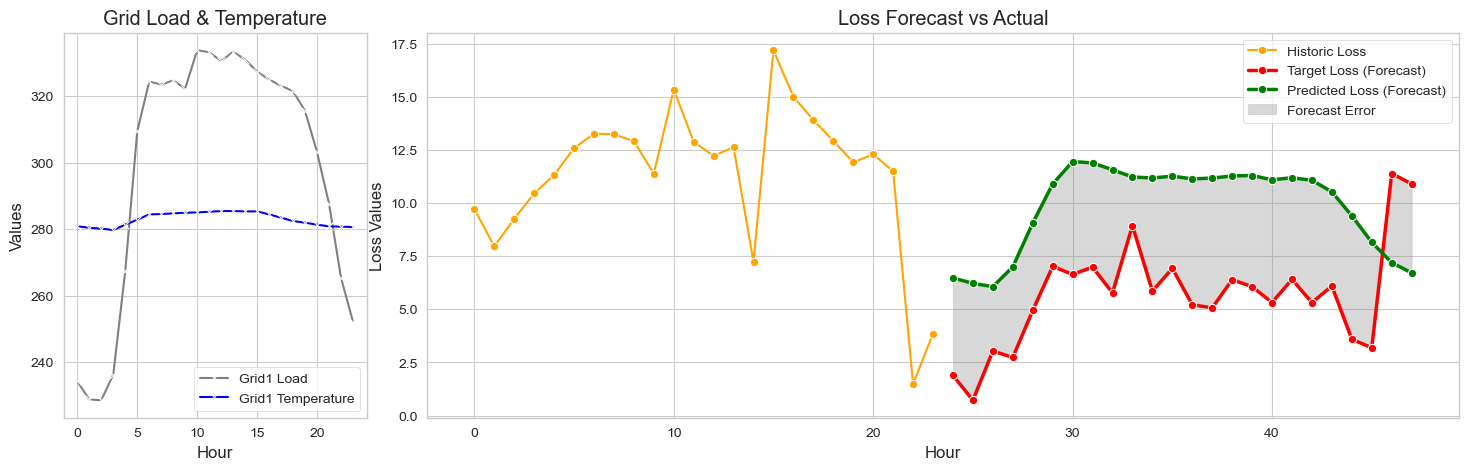

In [176]:


def plot_prediction(X, y, predicted):
    fig = plt.figure(figsize=(18, 5))
    random_index = np.random.randint(0, X.shape[0])
    
    # Create subplots with specific widths
    ax_left = plt.subplot2grid((1, 4), (0, 0), colspan=1)
    ax_right = plt.subplot2grid((1, 4), (0, 1), colspan=3)

    hours = np.arange(X.shape[1] // 3)
    target_hours = np.arange(len(hours), len(hours) + len(y[0]))

    load_values = X[random_index][0::3]
    temp_values = X[random_index][1::3]
    loss_values = X[random_index][2::3]

    # Left plot: Grid Load and Temperature
    sns.lineplot(x=hours, y=load_values, ax=ax_left, label="Grid1 Load", marker='x', color='grey')
    sns.lineplot(x=hours, y=temp_values, ax=ax_left, label="Grid1 Temperature", marker='x', color='blue')
    ax_left.set_title("Grid Load & Temperature")
    ax_left.set_xlabel("Hour")
    ax_left.set_ylabel("Values")
    ax_left.legend()
    ax_left.grid(True)

    # Right plot: Loss values and forecasts
    sns.lineplot(x=hours, y=loss_values, ax=ax_right, label="Historic Loss", marker='o', color='orange', linewidth=1.5)
    sns.lineplot(x=target_hours, y=y[random_index], ax=ax_right, label="Target Loss (Forecast)", marker='o', color='red', linewidth=2.5)
    sns.lineplot(x=target_hours, y=predicted[random_index], ax=ax_right, label="Predicted Loss (Forecast)", marker='o', color='green', linewidth=2.5)

    # Highlight error region between forecast and actual values
    ax_right.fill_between(target_hours, y[random_index], predicted[random_index], color='grey', alpha=0.3, label='Forecast Error')

    ax_right.set_title("Loss Forecast vs Actual")
    ax_right.set_xlabel("Hour")
    ax_right.set_ylabel("Loss Values")
    ax_right.legend()
    ax_right.grid(True)

    plt.show()

plot_prediction(X_test, y_test, predicted)